In [1]:
##import packages
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl 
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
import subprocess
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr,ttest_ind,mannwhitneyu
%matplotlib inline

warnings.filterwarnings('ignore')

#SpaOTsc
from spaotsc import SpaOTsc
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats

#novoSpaRc
import novosparc as nc
from scipy.spatial.distance import cdist
import h5py

# add Tangram to path
import anndata
import torch
import sys

sys.path.append("Tangram-master") 
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils


# 1. Part1 : grid spots with different pixes

In [2]:
### please the vefity that you have installed the Seurat,SpaOTsc,Tangram,novoSpaRc
### please  make sure you are in SpatialBenmarking dir and have prepared the data files
def Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateXlable, CoordinateYlable, window, outdir):
    if os.path.exists(outdir):
        print ('The output file is in ' + outdir)
    else:
        os.mkdir(outdir)
    combined_spot = []
    combined_spot_loc = []
    window=window
    c = 0
    for x in np.arange((spatial_loc[CoordinateXlable].min()//window),spatial_loc[CoordinateXlable].max()//window+1):
        for y in np.arange((spatial_loc[CoordinateYlable].min()//window),spatial_loc[CoordinateYlable].max()//window+1):
            tmp_loc = spatial_loc[(x*window < spatial_loc[CoordinateXlable]) & (spatial_loc[CoordinateXlable] < (x+1)*window) & (y*window < spatial_loc[CoordinateYlable]) & (spatial_loc[CoordinateYlable] < (y+1)*window)]
            if len(tmp_loc) > 0:
                c += 1
                combined_spot_loc.append([x,y])
                combined_spot.append(tmp_loc.index.to_list())
            
    combined_cell_counts = pd.DataFrame([len(s) for s in combined_spot],columns=['cell_count'])
    combined_cell_counts.to_csv(outdir + '/combined_cell_counts.txt',sep='\t')
    combined_cell_counts = pd.read_csv(outdir + '/combined_cell_counts.txt',sep='\t',index_col=0)
    print ('The simulated spot has cells with ' + str(combined_cell_counts.min()[0]) + ' to ' + str(combined_cell_counts.max()[0]))
    combined_spot_loc = pd.DataFrame(combined_spot_loc, columns=['x','y'])
    combined_spot_loc.to_csv(outdir + '/combined_Locations.txt',sep='\t',index=False)

    combined_spot_exp = []
    for s in combined_spot:
        combined_spot_exp.append(spatial_rna.loc[s,:].sum(axis=0).values)
    combined_spot_exp = pd.DataFrame(combined_spot_exp, columns=spatial_rna.columns)
    combined_spot_exp.to_csv(outdir + '/combined_spatial_count.txt',sep='\t',index=False)

    combined_spot_clusters = pd.DataFrame(np.zeros((len(combined_spot_loc.index),len(np.unique(spatial_meta['celltype'])))),columns=np.unique(spatial_meta['celltype']))
    for i,c in enumerate(combined_spot):
        for clt in spatial_meta.loc[c,'celltype']:
            combined_spot_clusters.loc[i,clt] += 1
    combined_spot_clusters.to_csv(outdir + '/combined_spot_clusters.txt',sep='\t')
    print ('The simulated spot has size ' + str(combined_spot_clusters.shape[0]))


# seqFISH+ datasetd simulated with 500 pixes

In [73]:

###before you simulated data, please check your cluster name and verfity that the cluster name in both data are same.
###please note that the cluster labels do not contain '/' or ' ' or '&'

sc_rna = pd.read_csv('seqFISH+/scRNA_count.txt', sep='\t',index_col=0, engine='c',low_memory=False)
sc_rna_meta = pd.read_csv('seqFISH+/allenvisp_scrna_meta.csv',index_col=0)
spatial_rna = pd.read_csv('seqFISH+/seqFISH_cortex_spatial_raw_exp.csv',index_col=0)
spatial_meta = pd.read_csv('seqFISH+/cortex_svz_cell_type_annotations.csv', index_col=0)
spatial_loc = pd.read_csv('seqFISH+/Locations_seqfish.txt',sep='\t')

spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]
spatial_meta = spatial_meta.loc[spatial_rna.index,:]


In [74]:
###spatial data cluster labels rename
celltype_mapper = {
    1:'Other',
    2:'Endo',
    3:'ExcitatoryL2&3',
    4:'ExcitatoryL5&6',
    5:'ExcitatoryL5&6',
    6:'ExcitatoryL4',
    7:'Inhibitory',
    8:'NSC',
    9:'ExcitatoryL2&3',
    10:'Astro',
    11:'ExcitatoryL5&6',
    12:'Neuroblast',
    13:'ExcitatoryL2&3',
    14:'NSC',
    15:'Neuralprogenitors',
    16:'Olig',
    17:'Neuroblasts',
    18:'ExcitatoryL5&6',
    19:'Astro',
    20:'Micro',
    21:'Neuroblast',
    22:'Ependymal',
    23:'Inhibitory',
    24:'Neuralprogenitors',
    25:'OPC',
    26:'Non-known',
}

spatial_meta['subclass'] = [celltype_mapper[c] for c in spatial_meta.louvain]
spatial_meta.to_csv( 'seqFISH+/spatial_meta.txt',sep = '\t')


In [75]:
###scRNA cluster labels rename
subclass_mapper = {
    'Astro':'Astro',
    'CR':'CR',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2&3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5&6',
    'L5PT':'ExcitatoryL5&6',
    'L6CT':'ExcitatoryL5&6',
    'L6IT':'ExcitatoryL5&6',
    'L6b':'ExcitatoryL5&6',
    'Lamp5':'Inhibitory',
    'Macrophage':'Micro',
    'Meis2':'Inhibitory',
    'NP':'ExcitatoryL5&6',
    'Oligo':'Olig',
    'Peri':'Peri',
    'Pvalb':'Inhibitory',
    'SMC':'Smc',
    'Serpinf1':'Inhibitory',
    'Sncg':'Inhibitory',
    'Sst':'Inhibitory',
    'VLMC':'VLMC',
    'Vip':'Inhibitory'
}

sc_rna_meta['subclass'] = [subclass_mapper[c] for c in sc_rna_meta['subclass']]
sc_rna_meta = pd.DataFrame(sc_rna_meta['celltype'])
sc_rna_meta.to_csv( 'seqFISH+/sc_rna_meta.txt',sep = '\t')



In [76]:

window = 500
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = 'Simulated_seqFISH+/'

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir)   


The output file is in Simulated_seqFISH+/
The simulated spot has cells with 1 to 17
The simulated spot has size 72


14


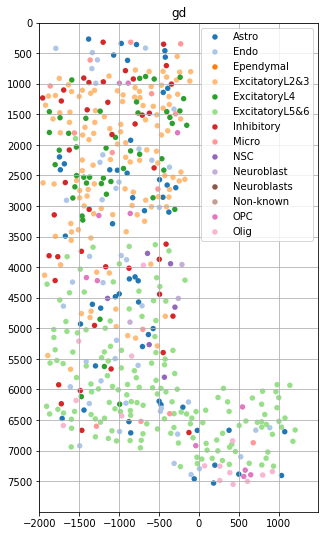

In [84]:
import matplotlib
spatial_meta = pd.read_csv('seqFISH+/spatial_meta.txt',sep='\t')
spatial_loc = pd.read_csv('seqFISH+/Locations_seqfish.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
print (len(np.unique(spatial_meta.celltype)))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(np.array(spatial_meta.celltype))))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['Y'][:-1],y=spatial_loc[spatial_meta['celltype'] == c]['X'][:-1],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(-2000,1500,500))
plt.yticks(np.arange(0,8000,500))
plt.xlim(-2000,1500)
plt.ylim(0,8000)
ax.invert_yaxis()
ax.invert_xaxis()
plt.grid()
plt.show()


# STARmap datasetd simulated with 750 pixes

In [5]:
sc_rna_meta = pd.read_csv('STARmap/allenvisp_scrna_meta.csv',index_col=0)
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'Other',
    'Vip':'Vip'
}

sc_rna_meta['celltype'] = [subclass_mapper[c] for c in sc_rna_meta['subclass']]
sc_rna_meta = pd.DataFrame(sc_rna_meta['celltype'])
sc_rna_meta.to_csv( 'STARmap/sc_rna_meta.txt',sep = '\t')

In [6]:

sc_rna = pd.read_csv('STARmap/scRNA_count.txt', sep='\t',index_col=0,engine='c',low_memory=False)
spatial_rna = pd.read_csv('STARmap/Spatial_rna.txt',sep='\t')
spatial_rna = spatial_rna.loc[:,spatial_rna.columns[spatial_rna.columns.isin(sc_rna.index)]]
print (spatial_rna.shape)
spatial_meta = pd.read_csv('STARmap/MetaData_Celltype.txt',sep='\t', index_col=0)
used_ind = [int(i.split('_')[1]) for i in spatial_meta.index]
spatial_meta.index = used_ind
celltypes = ['ExcitatoryL4','ExcitatoryL2and3','ExcitatoryL6','ExcitatoryL6','ExcitatoryL5','HPC','Vip','Pvalb','Sst','Npy','Olig','Endo','Micro','Astro','Other','Smc']
spatial_meta['celltype']=[celltypes[i] for i in spatial_meta.Cluster]
spatial_meta = spatial_meta.reset_index(drop=True)
spatial_loc = pd.read_csv('STARmap/Locations.txt',sep='\t')
spatial_loc = spatial_loc.loc[used_ind,:]
spatial_rna = spatial_rna.loc[used_ind,:]
spatial_loc = spatial_loc.reset_index(drop=True)
spatial_rna = spatial_rna.reset_index(drop=True)
spatial_meta.to_csv( 'STARmap/spatial_meta.txt',sep = '\t')
spatial_loc.to_csv( 'STARmap/spatial_loc.txt',sep = '\t',index = 0)
spatial_rna.to_csv( 'STARmap/spatial_count.txt',sep = '\t',index = 0)

window = 750
CoordinateX = 'X'
CoordinateY = 'Y'
outdir = 'Simulated_STARmap/'
spatial_rna = spatial_rna
spatial_meta = spatial_meta
spatial_loc = spatial_loc

Simulated(spatial_rna, spatial_meta, spatial_loc, CoordinateX, CoordinateY, window, outdir)  


(1549, 981)
The output file is in Simulated_STARmap/
The simulated spot has cells with 1 to 17
The simulated spot has size 189


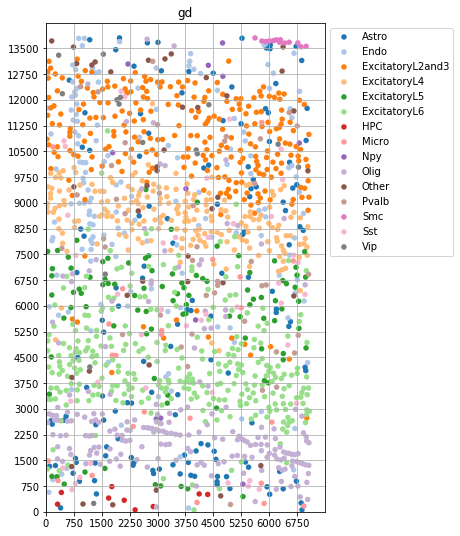

In [10]:
import matplotlib
%matplotlib inline
spatial_meta = pd.read_csv('STARmap/spatial_meta.txt',sep='\t')
spatial_loc = pd.read_csv('STARmap/spatial_loc.txt',sep='\t')
fig,ax = plt.subplots(figsize=(5,9))
cmap = sns.color_palette('tab20',n_colors=len(np.unique(spatial_meta.celltype)))
for i,c in enumerate(np.unique(spatial_meta.celltype)):
    ax.scatter(x=spatial_loc[spatial_meta['celltype'] == c]['X'],y=spatial_loc[spatial_meta['celltype'] == c]['Y'],c=matplotlib.colors.to_hex(cmap[i]),label=c,s=30,marker='o',edgecolors='none')
ax.set_title('gd')
ax.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(0,7500,750))
plt.yticks(np.arange(0,14250,750))
plt.xlim(0,7500)
plt.ylim(0,14250)
plt.grid()
plt.show()


# 2. Part2: Assigning each cell from an scRNA-seq analysis to a spot from a spatial transcriptomics analysis

In [85]:
class MappingCell:
    def __init__(self, RNA_path, Spatial_path, location_path, count_path = None, device = 'CPU', scrna_meta = None, subclass_mapper = None, gd_result = None, outdir = None):
        self.RNA_path = RNA_path
        self.Spatial_path = Spatial_path
        self.RNA_data =  pd.read_csv(RNA_path, sep='\t', index_col = 0)
        self.Spatial_data = pd.read_csv(Spatial_path, sep='\t', header=0)
        self.locations = np.loadtxt(location_path, skiprows=1)
        self.device = device
        if count_path != None:
            self.count =pd.read_csv(count_path,sep='\t', index_col = 0).astype(int)
        self.scrna_meta = scrna_meta
        self.subclass_mapper = subclass_mapper
        self.gd =  pd.read_csv(gd_result, sep='\t', index_col = 0)
        self.outdir = outdir

    def novoSpaRc(self):
        gene_names = self.RNA_data.index.values
        dge = self.RNA_data.values
        dge = dge.T
        num_cells = dge.shape[0]
        print ('number of cells and genes in the matrix:', dge.shape)
    
        hvg = np.argsort(np.divide(np.var(dge,axis=0),np.mean(dge,axis=0)+0.0001))
        dge_hvg = dge[:,hvg[-2000:]]
        
        num_locations = self.locations.shape[0]
    
        p_location, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)
        cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,self.locations,num_neighbors_source = 5,num_neighbors_target = 5)
        
        insitu_genes = self.Spatial_data.columns & gene_names
        insitu_matrix = self.Spatial_data.loc[:,insitu_genes]
        
        markers_in_sc = np.array([], dtype='int')
        for marker in insitu_genes:
            marker_index = np.where(gene_names == marker)[0]
            if len(marker_index) > 0:
                markers_in_sc = np.append(markers_in_sc, marker_index[0])
        
        cost_marker_genes = cdist(dge[:, markers_in_sc]/np.amax(dge[:, markers_in_sc]),insitu_matrix/np.amax(insitu_matrix))
        alpha_linear = 0.5
        gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(cost_marker_genes, cost_expression, cost_locations,alpha_linear, p_expression, p_location,'square_loss', epsilon=5e-3, verbose=True)
        print ('we use novoSpaRc to predict')
        np.save(self.outdir + '/novoSpaRc_alignment.npy',gw)
        novoSpaRc_map = gw
        sc_rna_meta = pd.read_csv(self.scrna_meta, sep = '\t', header = 0, index_col = 0)
        novoSpaRc_results=pd.DataFrame(np.zeros((novoSpaRc_map.shape[1],len(np.unique(sc_rna_meta['subclass'])))),columns=np.unique(sc_rna_meta['subclass']))
        for c in np.unique(sc_rna_meta['subclass']):
            novoSpaRc_results.loc[:,c] =  novoSpaRc_map[np.where(sc_rna_meta.subclass == c)[0],:].mean(axis=0)
        if self.subclass_mapper is not None:
            print ('Mapper is using') 
            novoSpaRc_results.columns = [self.subclass_mapper[c] for c in novoSpaRc_results.columns]
            novoSpaRc_pro_results = pd.DataFrame(np.zeros((len(novoSpaRc_results.index), len(np.unique(novoSpaRc_results.columns)))),columns=np.unique(novoSpaRc_results.columns))
            for c in np.unique(novoSpaRc_pro_results.columns):
                if len(novoSpaRc_results.loc[:,c].shape) > 1:
                    print (c)
                    novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].sum(axis=1).values
                else:
                    novoSpaRc_pro_results.loc[:,c] = novoSpaRc_results.loc[:,c].values
            novoSpaRc_results = novoSpaRc_pro_results
        CellType = novoSpaRc_results.columns & self.gd.columns
        novoSpaRc_results = novoSpaRc_results[CellType]
        novoSpaRc_results = (novoSpaRc_results.T/novoSpaRc_results.sum(axis=1)).T
        novoSpaRc_results = novoSpaRc_results.fillna(0)
        novoSpaRc_results.to_csv(self.outdir + '/novoSpaRc_CellType_Proportion.txt')     
        
    def SpaOTsc(self):
        df_sc = self.RNA_data.T
        df_IS = self.Spatial_data
        pts = self.locations
        is_dmat = distance_matrix(pts, pts)     
            
        df_is=df_IS    
        gene_is=df_is.columns.tolist()
        gene_sc=df_sc.columns.tolist()
        gene_overloap=list(set(gene_is).intersection(gene_sc))
        a=df_is[gene_overloap]
        b=df_sc[gene_overloap]
        
        
        rho, pval = stats.spearmanr(a, b,axis=1)
        rho[np.isnan(rho)]=0
        mcc=rho[-(len(df_sc)):,0:len(df_is)]
        C = np.exp(1-mcc) 

        issc = SpaOTsc.spatial_sc(sc_data=df_sc, is_data=df_is, is_dmat = is_dmat)
        print ('we use SpaOTsc to predict')
        issc.transport_plan(C**2, alpha=0, rho=1.0, epsilon=1.0, cor_matrix=mcc, scaling=False)
        gamma = issc.gamma_mapping
        for j in range(gamma.shape[1]):
            gamma[:,j] = gamma[:,j]/np.sum(gamma[:,j])
        np.save(self.outdir + '/SpaOTsc_alignment.npy',gamma)
        SpaOTsc_map = gamma
        sc_rna_meta = pd.read_csv(self.scrna_meta, sep = '\t', header = 0, index_col = 0)
        SpaOTsc_results=pd.DataFrame(np.zeros((SpaOTsc_map.shape[1],len(np.unique(sc_rna_meta['subclass'])))),columns=np.unique(sc_rna_meta['subclass']))
        for c in np.unique(sc_rna_meta['subclass']):
            SpaOTsc_results.loc[:,c] =  SpaOTsc_map[np.where(sc_rna_meta.subclass == c)[0],:].mean(axis=0)
        if self.subclass_mapper is not None:
            SpaOTsc_results.columns = [self.subclass_mapper[c] for c in SpaOTsc_results.columns]
            SpaOTsc_pro_results = pd.DataFrame(np.zeros((len(SpaOTsc_results.index), len(np.unique(SpaOTsc_results.columns)))),columns=np.unique(SpaOTsc_results.columns))
            for c in np.unique(SpaOTsc_pro_results.columns):
                if len(SpaOTsc_results.loc[:,c].shape) > 1:
                    print (c)
                    SpaOTsc_pro_results.loc[:,c] = SpaOTsc_results.loc[:,c].sum(axis=1).values
                else:
                    SpaOTsc_pro_results.loc[:,c] = SpaOTsc_results.loc[:,c].values
            SpaOTsc_results = SpaOTsc_pro_results
        CellType = SpaOTsc_results.columns & self.gd.columns
        SpaOTsc_results = SpaOTsc_results[CellType]
        SpaOTsc_results = (SpaOTsc_results.T/SpaOTsc_results.sum(axis=1)).T
        SpaOTsc_results = SpaOTsc_results.fillna(0)
        SpaOTsc_results.to_csv(self.outdir + '/SpaOTsc_CellType_proportion.txt')
    
    def Tangram(self,):
        rna_df = self.RNA_data
        adata = anndata.AnnData(rna_df.T)
        spatial_df = self.Spatial_data
        space_data = anndata.AnnData(spatial_df)
        combined_cell_counts = self.count
        space_data.obs['cell_count'] = combined_cell_counts.values
        space_data = space_data[space_data.obs['cell_count'] > 0]
        mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
            space_data.var_names, adata.var_names
        )
        S = np.array(adata[:, mask_adata_indices].X)
        G = np.array(space_data[:, mask_prior_indices].X)
        d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum()
        device = self.device
        if self.device == 'GPU':
            device = torch.device('cuda:0')
        hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
                'lambda_count' : 1, 'lambda_f_reg' : 1}
        learning_rate = 0.1
        num_epochs = 6000
        print ('we use Tangram to predict')
        mapper = mapping.mapping_optimizer.MapperConstrained(
            S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum()
        )
        output_all, F_out_all = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)
        sc_rna_meta = pd.read_csv(scrna_meta, sep = '\t', header=0,index_col = 0)
        adata.obs = sc_rna_meta
    
        df_classes = mapping.utils.one_hot_encoding(adata.obs.subclass)
        prob_assign = mapping.utils.transfer_annotations_prob_filter(output_all, F_out_all, df_classes)
        prob_assign.to_csv(self.outdir + '/Tangram_alignment.txt')
        Tangram_results = pd.read_csv(self.outdir + '/Tangram_alignment.txt',index_col=0)
        if self.subclass_mapper is not None:
            Tangram_results.columns = [self.subclass_mapper[c] for c in Tangram_results.columns]
            Tangram_pro_results = pd.DataFrame(np.zeros((len(Tangram_results.index), len(np.unique(Tangram_results.columns)))),columns=np.unique(Tangram_results.columns))
            for c in np.unique(Tangram_pro_results.columns):
                if len(Tangram_results.loc[:,c].shape) > 1:
                    Tangram_pro_results.loc[:,c] = Tangram_results.loc[:,c].sum(axis=1).values
                else:
                    Tangram_pro_results.loc[:,c] = Tangram_results.loc[:,c].values
            Tangram_results = Tangram_pro_results
        CellType = Tangram_results.columns & self.gd.columns
        Tangram_results = Tangram_results[CellType]
        Tangram_results = (Tangram_results.T/Tangram_results.sum(axis=1)).T
        Tangram_results = Tangram_results.fillna(0)
        Tangram_results.to_csv(self.outdir + '/Tangram_CellType_proportion.txt')
    
    def Seurat(self):
        rna_df = self.RNA_path
        spatial_df = self.Spatial_path
        scrna_meta = self.scrna_meta
        print ('we use seurat to predict')
        os.popen('Rscript Seurat_MappingCell.r ' + spatial_df + ' ' + rna_df + ' ' + scrna_meta + ' ' + self.outdir)
        print ('Rscript Seurat_MappingCell.r ' + spatial_df + ' ' + rna_df + ' ' + scrna_meta + ' ' + self.outdir)
        seurat_results = pd.read_csv(self.outdir + '/Seurat_alignment.txt', index_col=0)
        seurat_results = seurat_results.iloc[:,1:-1]
        Cols = seurat_results.columns
        used_ind = [(x.split('score.')[1]) for x in Cols]
        seurat_results.columns = used_ind
        seurat_results.index = np.arange(len(seurat_results))
        if self.subclass_mapper is not None:
            seurat_results.columns = [self.subclass_mapper[c] for c in seurat_results.columns]
            seurat_pro_results = pd.DataFrame(np.zeros((len(seurat_results.index), len(np.unique(seurat_results.columns)))),columns=np.unique(seurat_results.columns))
            for c in np.unique(seurat_results.columns):
                if len(seurat_pro_results.loc[:,c].shape) > 1:
                    seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].sum(axis=1).values
                else:
                    seurat_pro_results.loc[:,c] = seurat_results.loc[:,c].values
            seurat_results = seurat_pro_results
        CellType = seurat_results.columns & self.gd.columns
        seurat_results = seurat_results[CellType]
        seurat_results = (seurat_results.T/seurat_results.sum(axis=1)).T
        seurat_results = seurat_results.fillna(0)
        seurat_results.to_csv(self.outdir + '/seurat_CellType_proportion.txt')
        
        
    def workstart(self,Tools):
        if "novoSpaRc" in Tools:
            self.novoSpaRc()
        if "Tangram" in Tools:
            self.Tangram()
        if "Seurat" in Tools:
            self.Seurat()
        if "SpaOTsc" in Tools:
            self.SpaOTsc()




# STARmap data prediction

In [26]:
subclass_mapper = {
    'Astro':'Astro',
    'CR':'OtherExcitatory',
    'Endo':'Endo',
    'L2and3IT':'ExcitatoryL2and3',
    'L4':'ExcitatoryL4',
    'L5IT':'ExcitatoryL5',
    'L5PT':'ExcitatoryL5',
    'L6CT':'ExcitatoryL6',
    'L6IT':'ExcitatoryL6',
    'L6b':'ExcitatoryL6',
    'Lamp5':'OtherInhibitory',
    'Macrophage':'Micro',
    'Meis2':'OtherInhibitory',
    'NP':'ExcitatoryL5',
    'Oligo':'Olig',
    'Peri':'OtherEndo',
    'Pvalb':'Pvalb',
    'SMC':'Smc',
    'Serpinf1':'OtherInhibitory',
    'Sncg':'OtherInhibitory',
    'Sst':'Sst',
    'VLMC':'OtherCelltype',
    'Vip':'Vip'
}
scRNA = 'STARmap/scRNA_count.txt'
spatial_count = 'Simulated_STARmap/combined_spatial_count.txt'
cell_counts = 'Simulated_STARmap/combined_cell_counts.txt'
scrna_meta = 'STARmap/allenvisp_scrna_meta.csv'
gd_result = 'Simulated_STARmap/combined_spot_clusters.txt'
outdir = 'Result_STARmap/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
location = 'Simulated_STARmap/combined_Locations.txt'
MC = MappingCell(RNA_path = scRNA, Spatial_path = spatial_count, location_path = location, count_path = cell_counts, device = None, scrna_meta = scrna_meta, gd_result = gd_result, subclass_mapper = subclass_mapper, outdir = outdir)
Tools = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
MC.workstart(Tools)


number of cells and genes in the matrix: (14249, 34041)
Setting up for reconstruction ... done ( 363.96 seconds )
981
It.  |Err         
-------------------
    0|2.190068e-04|
we use novoSpaRc to predict
Mapper is using
we use seurat to SpaOTsc


# SeqFISH+ data prediction

In [86]:
scRNA = 'seqFISH+/scRNA_count.txt'
spatial_count = 'Simulated_seqFISH+/combined_spatial_count.txt'
cell_counts = 'Simulated_seqFISH+/combined_cell_counts.txt'
scrna_meta = 'seqFISH+/sc_rna_meta.txt'
gd_result = 'Simulated_seqFISH+/combined_spot_clusters.txt'
outdir = 'Result_seqFISH+/'
if not os.path.exists(outdir):
    os.mkdir(outdir)
location = 'Simulated_seqFISH+/combined_Locations.txt'
MC = MappingCell(RNA_path = scRNA, Spatial_path = spatial_count, location_path = location, count_path = cell_counts, device = None, scrna_meta = scrna_meta, gd_result = gd_result, outdir = outdir)
Tools = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
Tools = ['Tangram']
MC.workstart(Tools)


we use Tangram to predict
0.16009660065174103 0.7612773180007935 nan 6567.443359375 2937.943603515625
0.0008733510039746761 0.9049488306045532 nan 241.12838745117188 273.0485534667969
0.0006716176867485046 0.9076998233795166 nan 163.88674926757812 303.9849548339844
0.0007942018564790487 0.9053555130958557 nan 4.4310302734375 322.7075500488281
0.0009683059179224074 0.9027653932571411 nan 1.45477294921875 224.69717407226562
0.0010454622097313404 0.9012467861175537 nan 2.06787109375 181.41775512695312
0.0011045477585867047 0.8998344540596008 nan 1.0736083984375 149.84188842773438
0.001152932527475059 0.8989848494529724 nan 1.30255126953125 133.18385314941406
0.0012066514464095235 0.8983227610588074 nan 2.44091796875 116.44173431396484
0.0012404314475134015 0.8977565169334412 nan 0.056640625 109.20881652832031
0.0012830784544348717 0.8972648978233337 nan 2.20513916015625 98.04069519042969
0.0013154003536328673 0.8964442610740662 nan 1.1328125 87.78526306152344
0.0013395739952102304 0.89623

# 3. Part3: calculate the accuracy of each integration methods

In [87]:

def cal_ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim
def rsme(x1,x2):
    x1 = st.zscore(x1)
    x2 = st.zscore(x2)
    return mean_squared_error(x1,x2,squared=False)


def CalculateMetric(outdir,Methods,gd_celltype):
    data = []
    for Method in Methods:
        gd_results = pd.read_csv(gd_celltype,sep = '\t',index_col=0, header = 0)
        Predict_results = pd.read_csv(outdir + '/' + Method + '_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
        PCC = []
        SSIM = []
        JS = []
        RMSE = []
        CellTypeUse = Predict_results.columns & gd_results.columns
        Predict_results = Predict_results[CellTypeUse]
        gd_results = gd_results[CellTypeUse]
        gd_results = (gd_results.T/gd_results.sum(axis=1)).T
        gd_results = gd_results.fillna(0)
        print ('We Use Celltype Number ' + str(len(CellTypeUse)))
        for i in range(len(gd_results)):
            if np.max(gd_results.loc[i,:]) == 0 or np.max(Predict_results.loc[i,:]) == 0:
                PCC.append(P[0])
                SSIM.append(P[0])
                RMSE.append(1.5)
                JS.append(1)
            else:
                P = pearsonr(Predict_results.loc[i,:],gd_results.loc[i,:])
                PCC.append(P[0])
                SSIM.append(cal_ssim(Predict_results.loc[i,:],gd_results.loc[i,:]))
                RMSE.append(rsme(Predict_results.loc[i,:],gd_results.loc[i,:]))
                JSD = jensenshannon(Predict_results.loc[i,:],gd_results.loc[i,:])
                JS.append(JSD**2)
        
        PCC = np.nan_to_num(PCC, nan=0)
        SSIM = np.nan_to_num(SSIM, nan=0)
        RMSE = np.nan_to_num(RMSE, nan = 1.5)
        JS = np.nan_to_num(JS, nan=1)
        
        Metric = pd.DataFrame(PCC)
        Metric.columns = ['PCC']
        Metric['SSIM'] = SSIM
        Metric['RMSE'] = RMSE
        Metric['JS'] = JS
        Metric.to_csv(outdir + '/' + Method + '_Cellmapping_metric.txt',sep = '\t')   



# The accuracy of simulated data from seqFISH+ data 

In [88]:
Methods = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
outdir = 'Result_seqFISH+/'
CalculateMetric(outdir,Methods,'Simulated_seqFISH+/combined_spot_clusters.txt') 



We Use Celltype Number 8
We Use Celltype Number 8
We Use Celltype Number 8
We Use Celltype Number 8


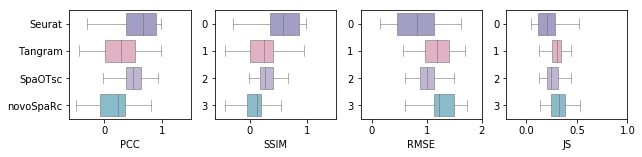

In [89]:
colors=['#9E97CC','#E9A9C2','#BFB1D7','#7EC0D6']
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10,2))
Seurat_Metric = pd.read_csv('Result_seqFISH+/Seurat_Cellmapping_metric.txt',sep = '\t')
Tangram_Metric = pd.read_csv('Result_seqFISH+/Tangram_Cellmapping_metric.txt',sep = '\t')
SpaOTsc_Metric = pd.read_csv('Result_seqFISH+/SpaOTsc_Cellmapping_metric.txt',sep = '\t')
novoSpaRc_Metric = pd.read_csv('Result_seqFISH+/novoSpaRc_Cellmapping_metric.txt',sep = '\t')

sns.boxplot(data=[np.array(Seurat_Metric['PCC']),np.array(Tangram_Metric['PCC']),np.array(SpaOTsc_Metric['PCC']),np.array(novoSpaRc_Metric['PCC'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[0])
axes[0].set_yticklabels(['Seurat','Tangram','SpaOTsc','novoSpaRc'])
axes[0].set_xlabel('PCC')
axes[0].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['SSIM']),np.array(Tangram_Metric['SSIM']),np.array(SpaOTsc_Metric['SSIM']),np.array(novoSpaRc_Metric['SSIM'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[1])
axes[1].set_xlabel('SSIM')
axes[1].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['RMSE']),np.array(Tangram_Metric['RMSE']),np.array(SpaOTsc_Metric['RMSE']),np.array(novoSpaRc_Metric['RMSE'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[2])
axes[2].set_xlabel('RMSE')
axes[2].set_xlim(-0.2,2.0)


sns.boxplot(data=[np.array(Seurat_Metric['JS']),np.array(Tangram_Metric['JS']),np.array(SpaOTsc_Metric['JS']),np.array(novoSpaRc_Metric['JS'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[3])
axes[3].set_xlabel('JS')
axes[3].set_xlim(-0.2,1)
plt.savefig('seqFISH_compare.pdf')

plt.show()


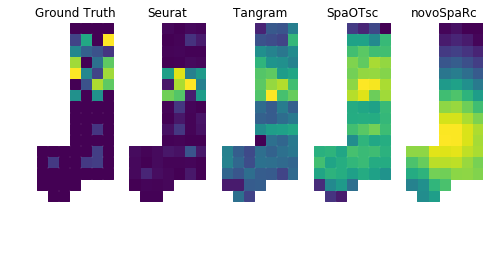

In [76]:

seurat_results = pd.read_csv('Result_seqFISH+/Seurat_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
tangram_results = pd.read_csv('Result_seqFISH+/Tangram_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
spa_results = pd.read_csv('Result_seqFISH+/SpaOTsc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
novo_results = pd.read_csv('Result_seqFISH+/novoSpaRc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)

gd_results = pd.read_csv('Simulated_seqFISH+/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv('Simulated_seqFISH+/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL4'

fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(8,3.9))
axes[0].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=gd_results[C][:-1],s=105,marker='s')
axes[0].set_ylim(-0.5,18.5)
axes[0].set_xlim(-4.5,2.5)
axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')

axes[1].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=seurat_results[C][:-1],s=105,marker='s')
axes[1].set_ylim(-0.5,18.5)
axes[1].set_xlim(-4.5,2.5)
axes[1].invert_yaxis()
axes[1].invert_xaxis()
axes[1].axis('off')
axes[1].set_title('Seurat')

axes[2].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=tangram_results[C][:-1],s=105,marker='s')
axes[2].set_ylim(-0.5,18.5)
axes[2].set_xlim(-4.5,2.5)
axes[2].invert_yaxis()
axes[2].invert_xaxis()
axes[2].axis('off')
axes[2].set_title('Tangram')

axes[3].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=spa_results[C][:-1],s=105,marker='s')
axes[3].set_ylim(-0.5,18.5)
axes[3].set_xlim(-4.5,2.5)
axes[3].invert_yaxis()
axes[3].invert_xaxis()
axes[3].axis('off')
axes[3].set_title('SpaOTsc')

axes[4].scatter(y=gd_loc['x'][:-1],x=gd_loc['y'][:-1],c=novo_results[C][:-1],s=105,marker='s')
axes[4].set_ylim(-0.5,18.5)
axes[4].set_xlim(-4.5,2.5)
axes[4].invert_yaxis()
axes[4].invert_xaxis()
axes[4].axis('off')
axes[4].set_title('novoSpaRc')

plt.show()


# The accuracy of simulated data from STARmap data 

In [32]:

Methods = ['Seurat','Tangram','SpaOTsc','novoSpaRc']
outdir = 'Result_STARmap/'
CalculateMetric(outdir,Methods,'Simulated_STARmap/combined_spot_clusters.txt')   




We Use Celltype Number 12
We Use Celltype Number 11
We Use Celltype Number 12
We Use Celltype Number 12


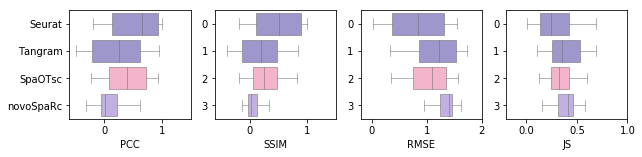

In [34]:
%matplotlib inline
colors=['#9E97CC','#E9A9C2','#BFB1D7','#7EC0D6']
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(10,2))
Seurat_Metric = pd.read_csv('Result_STARmap/Seurat_Cellmapping_metric.txt',sep = '\t')
Tangram_Metric = pd.read_csv('Result_STARmap/Tangram_Cellmapping_metric.txt',sep = '\t')
SpaOTsc_Metric = pd.read_csv('Result_STARmap/SpaOTsc_Cellmapping_metric.txt',sep = '\t')
novoSpaRc_Metric = pd.read_csv('Result_STARmap/novoSpaRc_Cellmapping_metric.txt',sep = '\t')

sns.boxplot(data=[np.array(Seurat_Metric['PCC']),np.array(Tangram_Metric['PCC']),np.array(SpaOTsc_Metric['PCC']),np.array(novoSpaRc_Metric['PCC'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[0])
axes[0].set_yticklabels(['Seurat','Tangram','SpaOTsc','novoSpaRc'])
axes[0].set_xlabel('PCC')
axes[0].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['SSIM']),np.array(Tangram_Metric['SSIM']),np.array(SpaOTsc_Metric['SSIM']),np.array(novoSpaRc_Metric['SSIM'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[1])
axes[1].set_xlabel('SSIM')
axes[1].set_xlim(-0.6,1.5)


sns.boxplot(data=[np.array(Seurat_Metric['RMSE']),np.array(Tangram_Metric['RMSE']),np.array(SpaOTsc_Metric['RMSE']),np.array(novoSpaRc_Metric['RMSE'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[2])
axes[2].set_xlabel('RMSE')
axes[2].set_xlim(-0.2,2.0)

sns.boxplot(data=[np.array(Seurat_Metric['JS']),np.array(Tangram_Metric['JS']),np.array(SpaOTsc_Metric['JS']),np.array(novoSpaRc_Metric['JS'])],fliersize=0,linewidth=0.5,palette=colors,orient='h',ax=axes[3])
axes[3].set_xlabel('JS')
axes[3].set_xlim(-0.2,1)

plt.show()


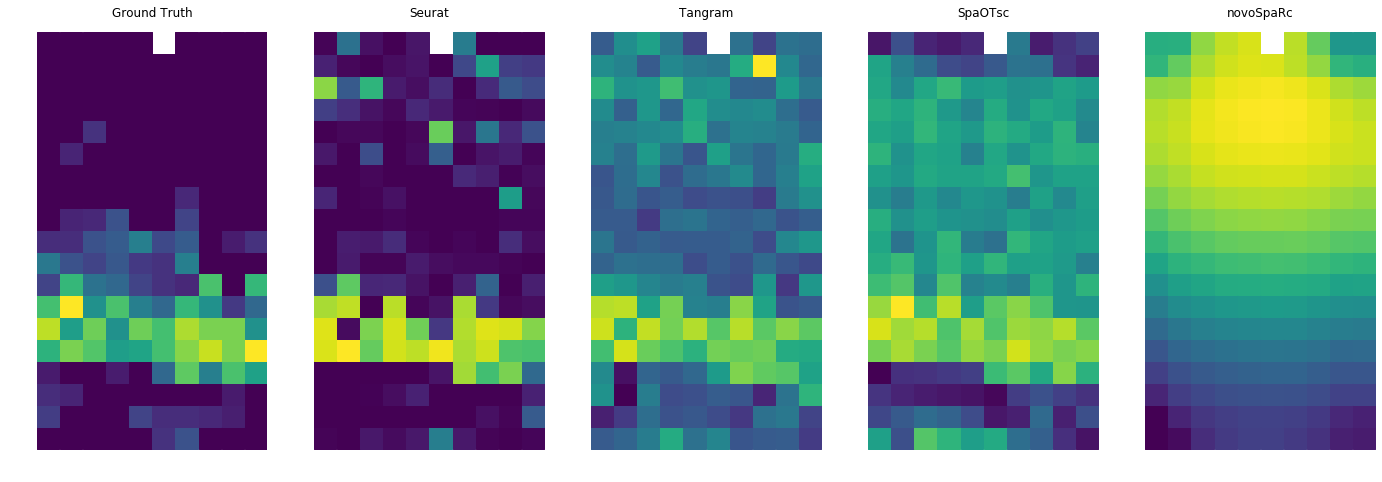

In [35]:
seurat_results = pd.read_csv('Result_STARmap/Seurat_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
tangram_results = pd.read_csv('Result_STARmap/Tangram_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
spa_results = pd.read_csv('Result_STARmap/SpaOTsc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)
novo_results = pd.read_csv('Result_STARmap/novoSpaRc_CellType_proportion.txt',sep = ',', header = 0, index_col = 0)

gd_results = pd.read_csv('Simulated_STARmap/combined_spot_clusters.txt',sep = '\t',index_col=0, header = 0)
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv('Simulated_STARmap/combined_Locations.txt',sep='\t')
C = 'ExcitatoryL6'

fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(24,8))
axes[0].scatter(x=gd_loc['x'],y=gd_loc['y'],c=gd_results[C],s=500,marker='s')
#axes[0].invert_yaxis()
#axes[0].invert_xaxis()
axes[0].axis('off')
axes[0].set_title('Ground Truth')

axes[1].scatter(x=gd_loc['x'],y=gd_loc['y'],c=seurat_results[C],s=500,marker='s')
#axes[1].invert_yaxis()
#axes[1].invert_xaxis()
axes[1].axis('off')
axes[1].set_title('Seurat')

axes[2].scatter(x=gd_loc['x'],y=gd_loc['y'],c=tangram_results[C],s=500,marker='s')
#axes[2].invert_yaxis()
#axes[2].invert_xaxis()
axes[2].axis('off')
axes[2].set_title('Tangram')

axes[3].scatter(x=gd_loc['x'],y=gd_loc['y'],c=spa_results[C],s=500,marker='s')
#axes[3].invert_yaxis()
#axes[3].invert_xaxis()
axes[3].axis('off')
axes[3].set_title('SpaOTsc')

axes[4].scatter(x=gd_loc['x'],y=gd_loc['y'],c=novo_results[C],s=500,marker='s')
#axes[4].invert_yaxis()
#axes[4].invert_xaxis()
axes[4].axis('off')
axes[4].set_title('novoSpaRc')

plt.show()